In [47]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,VotingClassifier
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from spotipy.oauth2 import time
import pandas as pd
import numpy as np
import time

In [8]:
def Open_Credentials():
    with open('credentials.txt') as f:
        lines = f.readlines()
    
    cid = lines[0].strip().split(':')[1].strip() if len(lines) > 0 else None
    secret = lines[1].strip().split(':')[1].strip() if len(lines) > 1 else None    
    if not cid or not secret:
        raise ValueError("Client ID or Client Secret is missing. Please check credentials.txt.")
    
    return cid,secret



def authorization_spotify(cid,secret):

    
    try:
        client_id=cid
        client_secret=secret
        client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
        sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, status_retries=5)
        return sp
    except Exception as e:
        raise Exception(f"An error occurred while trying to authenticate: {e}")
    try:
        sp1 = authorization_spotify()
        print("Authentication successful.")
    except Exception as error:
        print(error)


def authenticate_spotify(client_id, client_secret):
    credentials = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=credentials)
    return sp

# Function to get audio features of a song
def get_audio_features(sp, track_ids):
    features_list = []
    for track_id in track_ids:
        features = sp.audio_features(track_id)
        features_list.append(features[0])
    return features_list

def get_tracks_features(sp, genres, n_tracks=200, batch_size=50):
    tracks_data = []
    for genre in genres:
        for offset in range(0, n_tracks, batch_size):
            results = sp.search(q='genre:' + genre, type='track', limit=batch_size, offset=offset)
            for track in results['tracks']['items']:
                track_info = {
                    'name': track['name'],
                    'artist': track['artists'][0]['name'],
                    'id': track['id'],
                    'genre': genre
                }
                tracks_data.append(track_info)
            time.sleep(1)  
    return tracks_data


if __name__ == "__main__":
    cid,secret=Open_Credentials()
    authorization_spotify(cid,secret)
    sp = authenticate_spotify(cid, secret)
    
    genres = ['pop', 'rock', 'jazz', 'classical', 'hip-hop']
    tracks_data = get_tracks_features(sp, genres, n_tracks=50)
    
    track_ids = [track['id'] for track in tracks_data]
    audio_features = get_audio_features(sp, track_ids)
    df_tracks = pd.DataFrame(tracks_data)
    df_features = pd.DataFrame(audio_features)
    df = pd.concat([df_tracks, df_features], axis=1)
    df.to_csv('spotify_tracks.csv', index=False)
    


In [30]:


df = pd.read_csv('spotify_tracks.csv')

print("First few rows of the dataframe:")
print(df.head(10))

print("\nColumns of the DataDrame:")
print(df.columns)



df = df.loc[:, ~df.columns.duplicated()]

print("\nMissing values in each column:")
print(df.isnull().sum())
df.dropna(inplace=True)

numerical_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
    'duration_ms', 'time_signature'
]
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df = pd.get_dummies(df, columns=['genre'], drop_first=True)
df.to_csv('spotify_tracks_cleaned.csv', index=False)
print("\nFirst few rows of the cleaned dataframe:")
print(df.head())


First few rows of the dataframe:
                                     name                    artist  \
0                              Fisatomica            Paolo Bagnasco   
1                     Neem Me In Je Armen            Gert & Hermien   
2                     Dečak S Kraja Ulice            Marjana Deržaj   
3                          Muistatkos kun               Juha Vainio   
4                              Town Crier                Mike Bones   
5                                Bleeding  Sixpence None The Richer   
6        Kuoleman paikka - Por una cabeza                 Eino Grön   
7                     Страна воспоминаний              Edita Piekha   
8                         States Revealed              Dignan Porch   
9  Heute Lass Ich Alles Steh'n Und Liegen          Dennie Christian   

                       id genre  danceability  energy  key  loudness  mode  \
0  30VYBZ5lVQdXnWSzBBLbqk   pop         0.926   0.855    7    -7.435     1   
1  7jtnAauUlaBPzWAgMm1A22   p

In [17]:
# Load the cleaned data
df = pd.read_csv('spotify_tracks_cleaned.csv')

# Display summary statistics
print("Summary Statistics:")
print(df.describe())

# Display the first few rows of the dataframe
print("\nFirst few rows of the dataframe:")
print(df.head())


Summary Statistics:
       danceability        energy           key      loudness          mode  \
count  2.500000e+02  2.500000e+02  2.500000e+02  2.500000e+02  2.500000e+02   
mean   4.014566e-16  1.136868e-16 -8.881784e-17 -1.136868e-16  3.552714e-17   
std    1.002006e+00  1.002006e+00  1.002006e+00  1.002006e+00  1.002006e+00   
min   -2.218247e+00 -1.627365e+00 -1.490373e+00 -3.451958e+00 -1.277333e+00   
25%   -7.963084e-01 -8.635709e-01 -9.266916e-01 -5.112332e-01 -1.277333e+00   
50%    8.136110e-02  5.429977e-03 -8.117007e-02  1.975466e-01  7.828814e-01   
75%    8.379236e-01  8.804357e-01  7.643515e-01  7.986143e-01  7.828814e-01   
max    2.187198e+00  1.734853e+00  1.609873e+00  1.439742e+00  7.828814e-01   

        speechiness  acousticness  instrumentalness      liveness  \
count  2.500000e+02  2.500000e+02      2.500000e+02  2.500000e+02   
mean  -5.684342e-17 -7.105427e-17     -7.105427e-17 -1.918465e-16   
std    1.002006e+00  1.002006e+00      1.002006e+00  1.002006

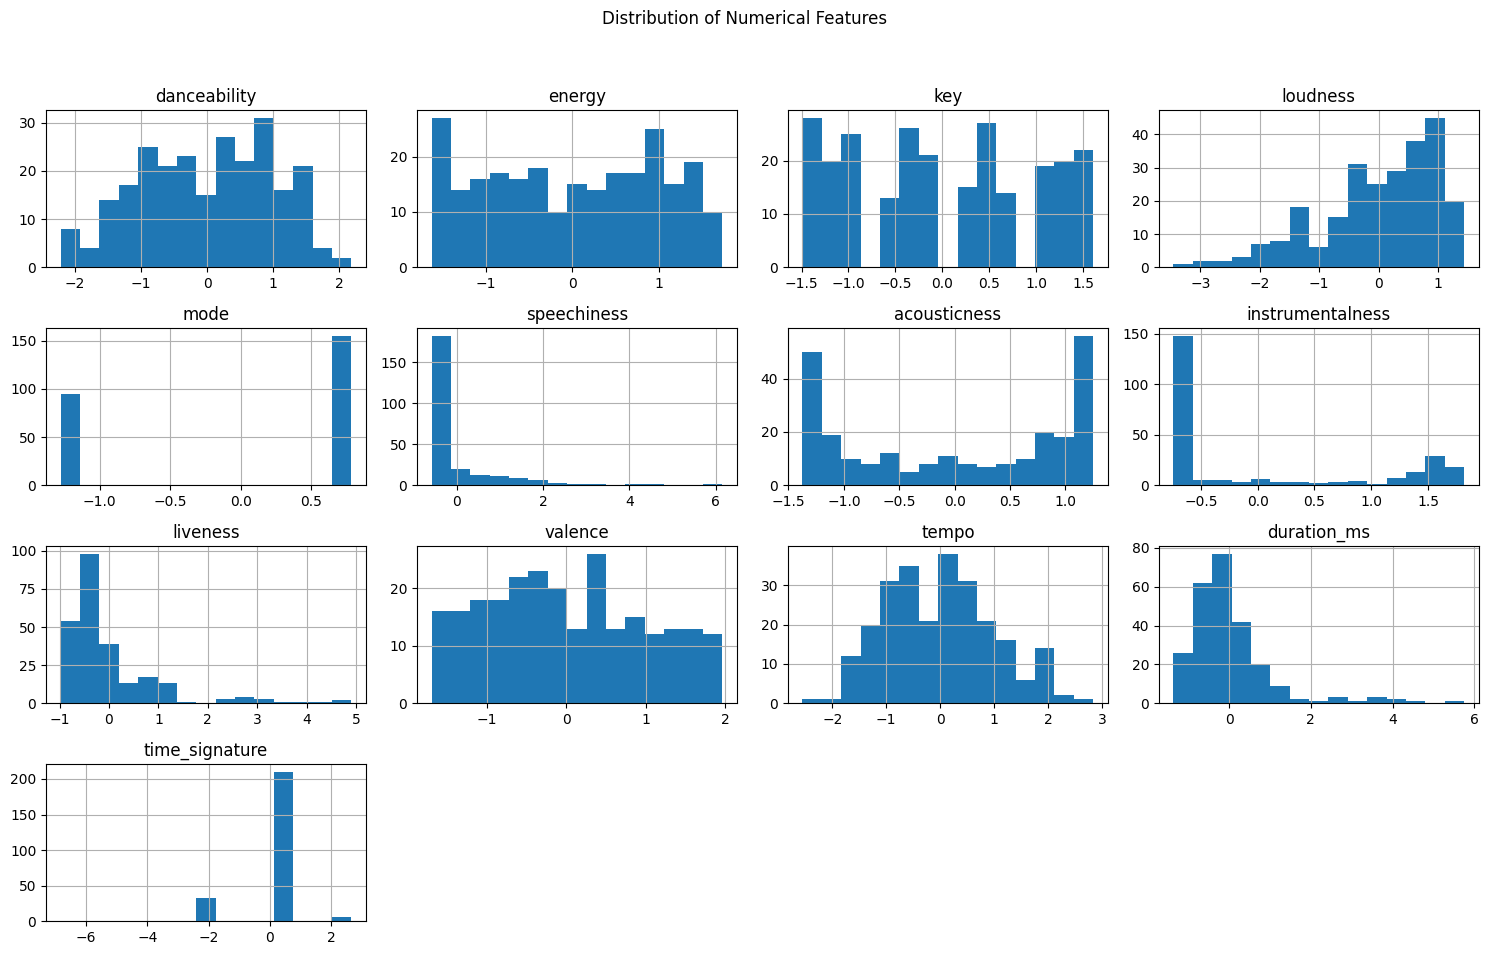

In [31]:
import matplotlib.pyplot as plt

numerical_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
    'duration_ms', 'time_signature'
]

df[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



Non-numeric columns:
Index(['name', 'artist', 'id', 'type', 'id.1', 'uri', 'track_href',
       'analysis_url', 'genre_hip-hop', 'genre_jazz', 'genre_pop',
       'genre_rock'],
      dtype='object')

Remaining non-numeric columns after drop:
Index([], dtype='object')


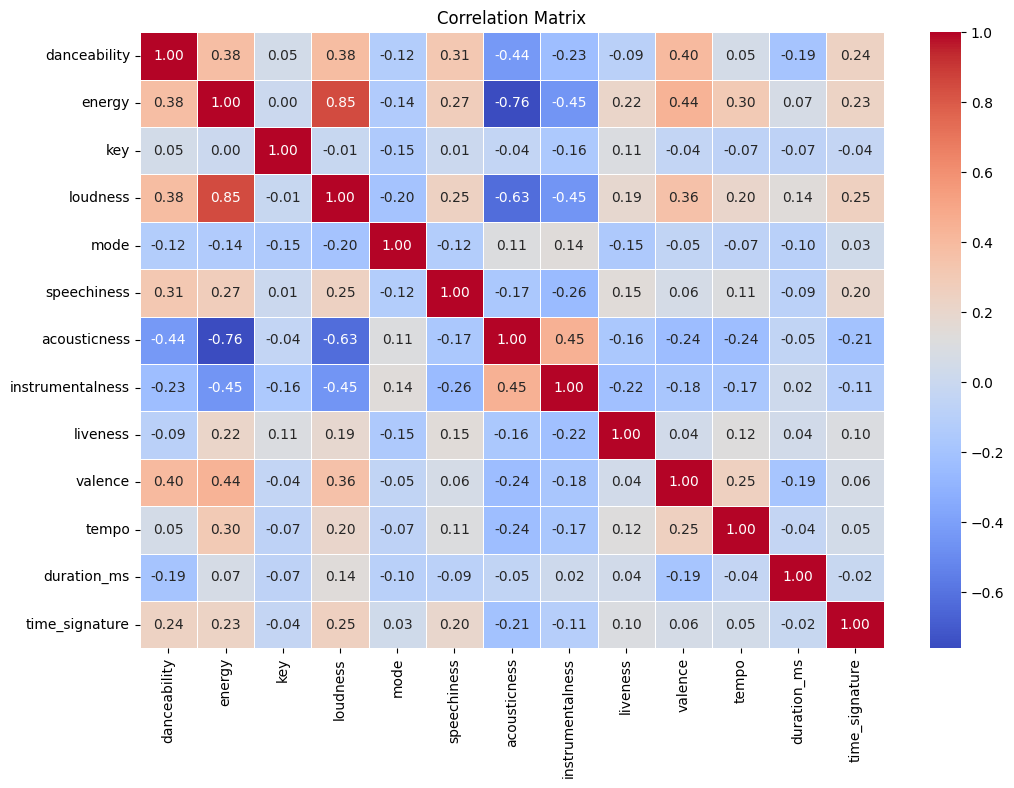

In [32]:
import seaborn as sns

df = pd.read_csv('spotify_tracks_cleaned.csv')
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
print("\nNon-numeric columns:")
print(non_numeric_columns)

df_numeric = df.drop(columns=non_numeric_columns)
print("\nRemaining non-numeric columns after drop:")
print(df_numeric.select_dtypes(exclude=[np.number]).columns)
corr_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


Column names in the dataset:
Index(['name', 'artist', 'id', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id.1', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'genre_hip-hop', 'genre_jazz',
       'genre_pop', 'genre_rock'],
      dtype='object')
One-hot encoded genre columns:
['genre_hip-hop', 'genre_jazz', 'genre_pop', 'genre_rock']


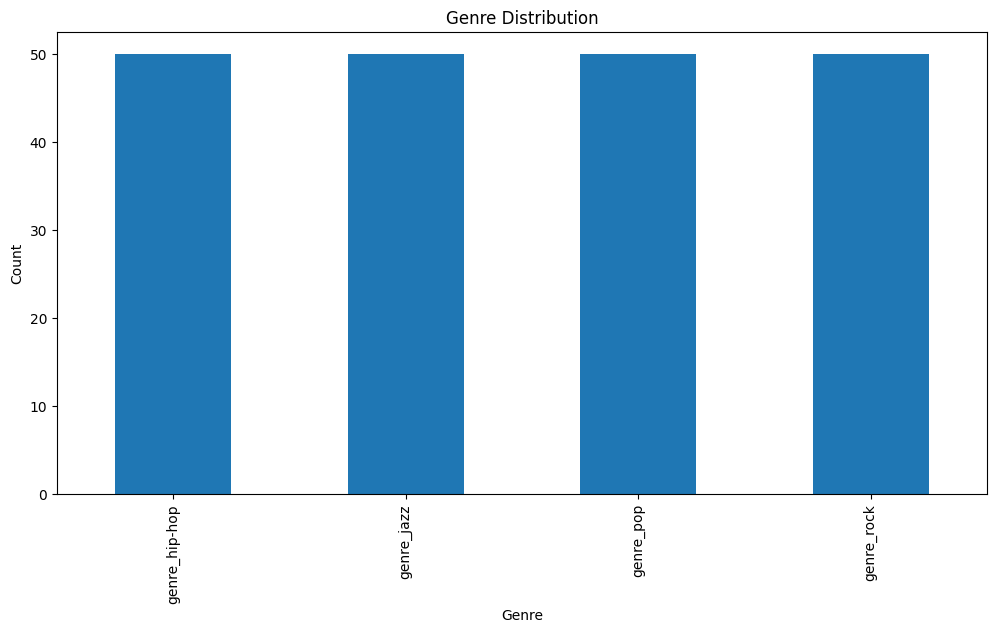

In [33]:
df = pd.read_csv('spotify_tracks_cleaned.csv')
print("Column names in the dataset:")
print(df.columns)

if 'genre' in df.columns:
    plt.figure(figsize=(12, 6))
    df['genre'].value_counts().plot(kind='bar')
    plt.title("Genre Distribution")
    plt.xlabel("Genre")
    plt.ylabel("Count")
    plt.show()
else:
    genre_columns = [col for col in df.columns if col.startswith('genre_')]
    print("One-hot encoded genre columns:")
    print(genre_columns)
    genre_counts = df[genre_columns].sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    genre_counts.plot(kind='bar')
    plt.title("Genre Distribution")
    plt.xlabel("Genre")
    plt.ylabel("Count")
    plt.show()


In [34]:

df = pd.read_csv('spotify_tracks_cleaned.csv')

print("First few rows of the dataframe:")
display(df.head())

X = df.drop(columns=[col for col in df.columns if col.startswith('genre_')])

y = df[[col for col in df.columns if col.startswith('genre_')]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


First few rows of the dataframe:


,name,artist,id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,id.1,uri,track_href,analysis_url,duration_ms,time_signature,genre_hip-hop,genre_jazz,genre_pop,genre_rock
0,Fisatomica,Paolo Bagnasco,30VYBZ5lVQdXnWSzBBLbqk,2.187198,1.305929,0.482511,0.704992,0.782881,-0.371317,-0.551206,...,30VYBZ5lVQdXnWSzBBLbqk,spotify:track:30VYBZ5lVQdXnWSzBBLbqk,https://api.spotify.com/v1/tracks/30VYBZ5lVQdX...,https://api.spotify.com/v1/audio-analysis/30VY...,-0.518566,0.284747,False,False,True,False
1,Neem Me In Je Armen,Gert & Hermien,7jtnAauUlaBPzWAgMm1A22,0.711117,-0.221042,-1.490373,0.006573,0.782881,-0.579835,0.768939,...,7jtnAauUlaBPzWAgMm1A22,spotify:track:7jtnAauUlaBPzWAgMm1A22,https://api.spotify.com/v1/tracks/7jtnAauUlaBP...,https://api.spotify.com/v1/audio-analysis/7jtn...,-0.360343,0.284747,False,False,True,False
2,Dečak S Kraja Ulice,Marjana Deržaj,5Ba7xXsaA6DOmP5vCDhMUw,-0.252039,-0.498985,0.482511,0.097605,-1.277333,0.972626,0.671443,...,5Ba7xXsaA6DOmP5vCDhMUw,spotify:track:5Ba7xXsaA6DOmP5vCDhMUw,https://api.spotify.com/v1/tracks/5Ba7xXsaA6DO...,https://api.spotify.com/v1/audio-analysis/5Ba7...,-0.734574,0.284747,False,False,True,False
3,Muistatkos kun,Juha Vainio,7p09wWuXQoZrCBOGZmR18h,0.921986,0.496119,0.482511,0.661617,-1.277333,0.140029,0.413211,...,7p09wWuXQoZrCBOGZmR18h,spotify:track:7p09wWuXQoZrCBOGZmR18h,https://api.spotify.com/v1/tracks/7p09wWuXQoZr...,https://api.spotify.com/v1/audio-analysis/7p09...,-0.361426,0.284747,False,False,True,False
4,Town Crier,Mike Bones,3qP8PUV7WwYioYgghIFCGE,0.671223,0.763768,-0.081170,0.278011,0.782881,-0.478892,0.115454,...,3qP8PUV7WwYioYgghIFCGE,spotify:track:3qP8PUV7WwYioYgghIFCGE,https://api.spotify.com/v1/tracks/3qP8PUV7WwYi...,https://api.spotify.com/v1/audio-analysis/3qP8...,0.950446,0.284747,False,False,True,False


Training set size: (200, 21)
Testing set size: (50, 21)


In [40]:
# Train Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100)
gb_clf.fit(X_train, y_train)

# Evaluate the Gradient Boosting Classifier
y_pred_gb_clf = gb_clf.predict(X_test)
print("Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, y_pred_gb_clf))
print(classification_report(y_test, y_pred_gb_clf))


Gradient Boosting Classifier Accuracy: 0.68
               precision    recall  f1-score   support

genre_hip-hop       0.85      0.85      0.85        20
   genre_jazz       0.75      0.90      0.82        10
    genre_pop       0.55      0.46      0.50        13
   genre_rock       0.29      0.29      0.29         7

     accuracy                           0.68        50
    macro avg       0.61      0.62      0.61        50
 weighted avg       0.67      0.68      0.67        50



In [44]:

rf_clf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
svm_clf = SVC(**grid_search_svm.best_params_, probability=True, random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)

# Create the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('svm', svm_clf),
        ('gb', gb_clf)
    ],
    voting='soft'
)

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# Evaluate the Voting Classifier
y_pred_voting_clf = voting_clf.predict(X_test)
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting_clf))
print(classification_report(y_test, y_pred_voting_clf))


Voting Classifier Accuracy: 0.68
               precision    recall  f1-score   support

genre_hip-hop       0.80      0.80      0.80        20
   genre_jazz       0.75      0.90      0.82        10
    genre_pop       0.55      0.46      0.50        13
   genre_rock       0.43      0.43      0.43         7

     accuracy                           0.68        50
    macro avg       0.63      0.65      0.64        50
 weighted avg       0.67      0.68      0.67        50



In [45]:
df = pd.read_csv('spotify_tracks_cleaned.csv')
columns_to_drop = ['name', 'artist', 'id', 'type', 'id.1', 'uri', 'track_href', 'analysis_url']
df = df.drop(columns=columns_to_drop)

X = df.drop(columns=[col for col in df.columns if col.startswith('genre_')])
y = df[[col for col in df.columns if col.startswith('genre_')]]

# Convert one-hot encoded labels to single labels
y = y.idxmax(axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, multi_class='ovr')
log_reg.fit(X_train, y_train)

# Evaluate the Logistic Regression model
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

# Hyperparameter tuning for Random Forest Classifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)

# Evaluate the best Random Forest model
best_rf_clf = grid_search_rf.best_estimator_
y_pred_rf_clf = best_rf_clf.predict(X_test)
print("Tuned Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf_clf))
print(classification_report(y_test, y_pred_rf_clf))

# Hyperparameter tuning for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search_svm = GridSearchCV(estimator=SVC(random_state=42), param_grid=param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train, y_train)

print("Best parameters for SVM:", grid_search_svm.best_params_)

# Evaluate the best SVM model
best_svm_clf = grid_search_svm.best_estimator_
y_pred_svm_clf = best_svm_clf.predict(X_test)
print("Tuned SVM Classifier Accuracy:", accuracy_score(y_test, y_pred_svm_clf))
print(classification_report(y_test, y_pred_svm_clf))

# Train and evaluate Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb_clf = gb_clf.predict(X_test)
print("Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, y_pred_gb_clf))
print(classification_report(y_test, y_pred_gb_clf))

# Define the base models for Voting Classifier
rf_clf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
svm_clf = SVC(**grid_search_svm.best_params_, probability=True, random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)

# Create the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('svm', svm_clf),
        ('gb', gb_clf)
    ],
    voting='soft'
)

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# Evaluate the Voting Classifier
y_pred_voting_clf = voting_clf.predict(X_test)
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting_clf))
print(classification_report(y_test, y_pred_voting_clf))


Training set size: (200, 13)
Testing set size: (50, 13)
Logistic Regression Accuracy: 0.72
               precision    recall  f1-score   support

genre_hip-hop       0.94      0.75      0.83        20
   genre_jazz       0.75      0.90      0.82        10
    genre_pop       0.67      0.62      0.64        13
   genre_rock       0.40      0.57      0.47         7

     accuracy                           0.72        50
    macro avg       0.69      0.71      0.69        50
 weighted avg       0.75      0.72      0.73        50

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Tuned Random Forest Classifier Accuracy: 0.6
               precision    recall  f1-score   support

genre_hip-hop       0.65      0.75      0.70        20
   genre_jazz       0.73      0.80      0.76        10
    genre_pop       0.40      0.31      0.35        13
   genre_rock    

In [46]:
from sklearn.model_selection import GridSearchCV

# Grid Search for Random Forest Classifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf_clf = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}


# 50 Calls 

In [49]:
df = pd.read_csv('spotify_tracks_cleaned.csv')
columns_to_drop = ['name', 'artist', 'id', 'type', 'id.1', 'uri', 'track_href', 'analysis_url']
df = df.drop(columns=columns_to_drop)

X = df.drop(columns=[col for col in df.columns if col.startswith('genre_')])
y = df[[col for col in df.columns if col.startswith('genre_')]]

y = y.idxmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_space = [
    Integer(50, 300, name='n_estimators'),
    Integer(10, 50, name='max_depth'),
    Integer(2, 15, name='min_samples_split'),
    Integer(1, 10, name='min_samples_leaf')
]

rf_clf = RandomForestClassifier(random_state=42)

@use_named_args(param_space)
def objective(**params):
    rf_clf.set_params(**params)
    return -np.mean(cross_val_score(rf_clf, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy'))

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=50, random_state=42, verbose=10)

# Print the best hyperparameters
print("Best hyperparameters found by Bayesian Optimization:")
print("n_estimators:", res_gp.x[0])
print("max_depth:", res_gp.x[1])
print("min_samples_split:", res_gp.x[2])
print("min_samples_leaf:", res_gp.x[3])

# Train the Random Forest model with the best hyperparameters
best_rf_clf_bayesian = RandomForestClassifier(
    n_estimators=res_gp.x[0],
    max_depth=res_gp.x[1],
    min_samples_split=res_gp.x[2],
    min_samples_leaf=res_gp.x[3],
    random_state=42
)
best_rf_clf_bayesian.fit(X_train, y_train)

# Evaluate the best model
y_pred_best_rf_bayesian = best_rf_clf_bayesian.predict(X_test)
print("Random Forest Classifier Accuracy with Best Parameters (Bayesian Optimization):", accuracy_score(y_test, y_pred_best_rf_bayesian))
print(classification_report(y_test, y_pred_best_rf_bayesian))


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2732
Function value obtained: -0.6700
Current minimum: -0.6700
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1987
Function value obtained: -0.6850
Current minimum: -0.6850
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1187
Function value obtained: -0.6950
Current minimum: -0.6950
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3089
Function value obtained: -0.6650
Current minimum: -0.6950
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2198
Function value obtained: -0.6750
Current minimum: -0.6950
Iteration No: 6 started. 

# 100 Calls

In [50]:

df = pd.read_csv('spotify_tracks_cleaned.csv')

columns_to_drop = ['name', 'artist', 'id', 'type', 'id.1', 'uri', 'track_href', 'analysis_url']
df = df.drop(columns=columns_to_drop)


X = df.drop(columns=[col for col in df.columns if col.startswith('genre_')])
y = df[[col for col in df.columns if col.startswith('genre_')]]

y = y.idxmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_space = [
    Integer(50, 400, name='n_estimators'),
    Integer(5, 50, name='max_depth'),
    Integer(2, 20, name='min_samples_split'),
    Integer(1, 10, name='min_samples_leaf')
]

# Define the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Define the objective function
@use_named_args(param_space)
def objective(**params):
    rf_clf.set_params(**params)
    return -np.mean(cross_val_score(rf_clf, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy'))

# Perform Bayesian Optimization with more iterations
res_gp = gp_minimize(objective, param_space, n_calls=100, random_state=42, verbose=10)

# Print the best hyperparameters
print("Best hyperparameters found by Bayesian Optimization:")
print("n_estimators:", res_gp.x[0])
print("max_depth:", res_gp.x[1])
print("min_samples_split:", res_gp.x[2])
print("min_samples_leaf:", res_gp.x[3])

# Train the Random Forest model with the best hyperparameters
best_rf_clf_bayesian = RandomForestClassifier(
    n_estimators=res_gp.x[0],
    max_depth=res_gp.x[1],
    min_samples_split=res_gp.x[2],
    min_samples_leaf=res_gp.x[3],
    random_state=42
)
best_rf_clf_bayesian.fit(X_train, y_train)

# Evaluate the best model
y_pred_best_rf_bayesian = best_rf_clf_bayesian.predict(X_test)
print("Random Forest Classifier Accuracy with Best Parameters (Bayesian Optimization):", accuracy_score(y_test, y_pred_best_rf_bayesian))
print(classification_report(y_test, y_pred_best_rf_bayesian))


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3651
Function value obtained: -0.6600
Current minimum: -0.6600
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2339
Function value obtained: -0.6700
Current minimum: -0.6700
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1273
Function value obtained: -0.6900
Current minimum: -0.6900
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3845
Function value obtained: -0.6650
Current minimum: -0.6900
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2922
Function value obtained: -0.6800
Current minimum: -0.6900
Iteration No: 6 started. 

c:\Users\msouh\.conda\envs\mynewenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [53, 9, 2, 1] before, using random point [160, 41, 3, 6]
  warnings.warn(


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 0.6553
Function value obtained: -0.6850
Current minimum: -0.7350
Iteration No: 88 started. Searching for the next optimal point.
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 0.9034
Function value obtained: -0.6700
Current minimum: -0.7350
Iteration No: 89 started. Searching for the next optimal point.
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 0.9466
Function value obtained: -0.7000
Current minimum: -0.7350
Iteration No: 90 started. Searching for the next optimal point.
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 0.5918
Function value obtained: -0.7250
Current minimum: -0.7350
Iteration No: 91 started. Searching for the next optimal point.
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.0416
Function value obtained: -0.7000
Current minimum: -0.7350
Iteration No: 92 st

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report

df = pd.read_csv('spotify_tracks_cleaned.csv')
columns_to_drop = ['name', 'artist', 'id', 'type', 'id.1', 'uri', 'track_href', 'analysis_url']
df = df.drop(columns=columns_to_drop)
X = df.drop(columns=[col for col in df.columns if col.startswith('genre_')])
y = df[[col for col in df.columns if col.startswith('genre_')]]
y = y.idxmax(axis=1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')


y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred_classes))





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 3108 (12.14 KB)
Trainable params: 3108 (12.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


5/5 - 

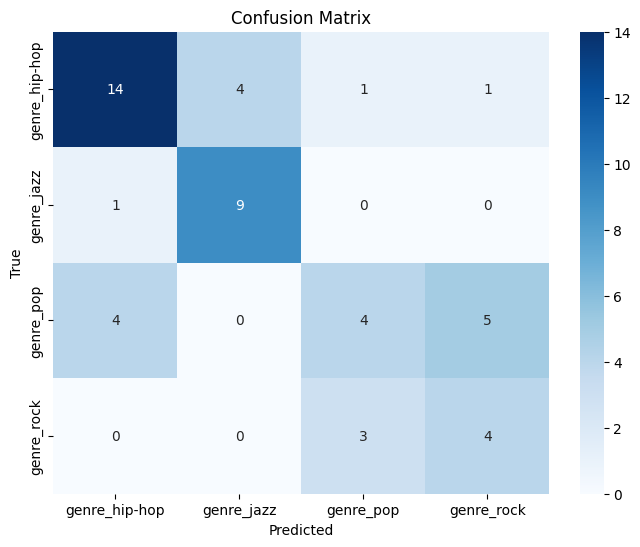

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
